In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb

# Load your dataset
df = pd.read_csv("/content/filtered_2014_2024.csv")

# Extract state name from file name
df['state'] = df['SourceFile'].apply(lambda x: x.replace('.csv', ''))

# Filter only Punjab data
punjab_df = df[df['state'] == 'Punjab'].copy()

# Set target column
target_column = 'utci_mean'

# Define X and y
X = punjab_df.drop(columns=['date', 'SourceFile', 'state', target_column])
y = punjab_df[target_column]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# XGBoost Regressor model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Print results
print("✅ XGBoost Results for Punjab:")
print(f"R² Score : {r2:.4f}")
print(f"RMSE     : {rmse:.2f}")
print(f"MAE      : {mae:.2f}")
print(f"MAPE (%) : {mape:.2f}")


✅ XGBoost Results for Punjab:
R² Score : 0.9931
RMSE     : 0.56
MAE      : 0.44
MAPE (%) : 0.15


<ipython-input-12-82c8694d61af>:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


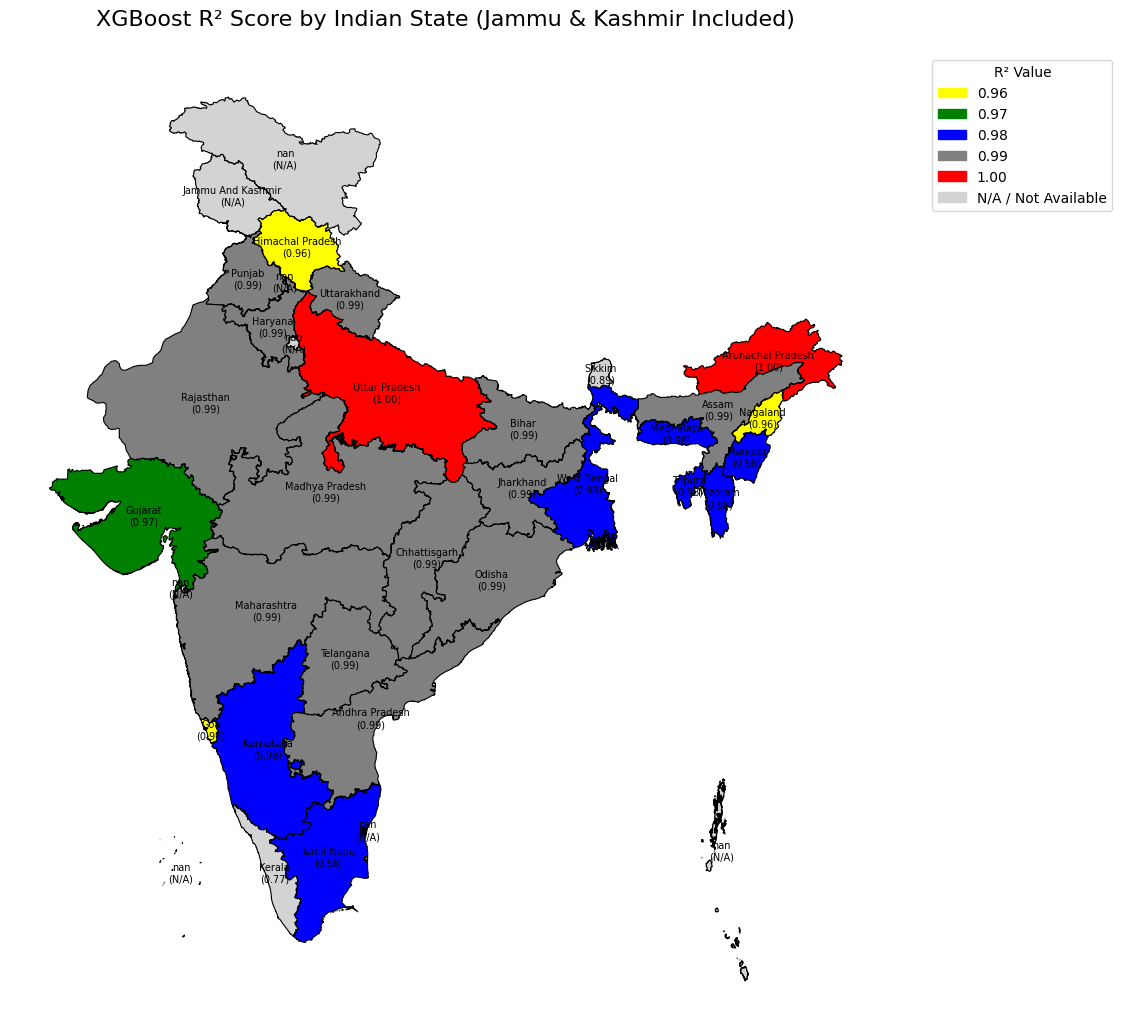

In [12]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === LOAD SHAPEFILE AND RESULTS ===
india_states = gpd.read_file("/content/Admin2.shp")
results = pd.read_csv("/content/xgboost_all_states_results.csv")

# === CLEAN STATE NAMES ===
india_states['ST_NM'] = india_states['ST_NM'].str.replace('&', 'and', regex=False)
india_states['ST_NM'] = india_states['ST_NM'].str.strip().str.title()
results['State'] = results['State'].str.replace('_', ' ')
results['State'] = results['State'].str.strip().str.title()

# === ADD JAMMU AND KASHMIR IF MISSING ===
if "Jammu And Kashmir" not in results['State'].values:
    new_row = pd.DataFrame([{
        'State': 'Jammu And Kashmir',
        'R2 Score': pd.NA,
        'Rounded R2': pd.NA,
        'Color': 'lightgray'
    }])
    results = pd.concat([results, new_row], ignore_index=True)

# === ROUND R² AND ASSIGN COLORS ===
results['Rounded R2'] = results['R2 Score'].round(2)
color_map = {
    0.96: 'yellow',
    0.97: 'green',
    0.98: 'blue',
    0.99: 'gray',
    1.00: 'red'
}
results['Color'] = results['Rounded R2'].map(color_map).fillna('lightgray')

# === MERGE SHAPEFILE AND RESULTS ===
merged = india_states.merge(results, left_on='ST_NM', right_on='State', how='left')
merged['Color'] = merged['Color'].fillna('lightgray')

# === PLOT MAP ===
fig, ax = plt.subplots(figsize=(15, 12))
merged.plot(color=merged['Color'], linewidth=0.8, edgecolor='black', ax=ax)

# Add R² text labels
for idx, row in merged.iterrows():
    if row['geometry'].centroid.is_empty:
        continue
    x, y = row['geometry'].centroid.coords[0]
    label = f"{row['State']}\n({row['R2 Score']:.2f})" if pd.notnull(row['R2 Score']) else f"{row['State']}\n(N/A)"
    ax.text(x, y, label, ha='center', va='center', fontsize=7)

# Add legend
legend_labels = [
    mpatches.Patch(color='yellow', label='0.96'),
    mpatches.Patch(color='green', label='0.97'),
    mpatches.Patch(color='blue', label='0.98'),
    mpatches.Patch(color='gray', label='0.99'),
    mpatches.Patch(color='red', label='1.00'),
    mpatches.Patch(color='lightgray', label='N/A / Not Available')
]
plt.legend(handles=legend_labels, title="R² Value", bbox_to_anchor=(1.05, 1), loc='upper left')

# Final layout
plt.title("XGBoost R² Score by Indian State (Jammu & Kashmir Included)", fontsize=16, pad=20)
plt.axis('off')
plt.subplots_adjust(top=0.92)
plt.show()


In [ ]:
pip install geopandas matplotlib


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Admin2.shp to Admin2.shp
Saving Admin2.shx to Admin2.shx
Saving Admin2.prj to Admin2.prj
Saving Admin2.dbf to Admin2.dbf
Saving Admin2.cpg to Admin2.cpg


In [ ]:
india_states.columns


Index(['ST_NM', 'geometry'], dtype='object')

In [ ]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# Load your dataset
df = pd.read_csv("/content/filtered_2014_2024.csv")
df['state'] = df['SourceFile'].apply(lambda x: x.replace('.csv', ''))

# Define target column
target = 'utci_mean'

# Prepare results list
results = []

# Loop through each state
for state in df['state'].unique():
    state_df = df[df['state'] == state].copy()

    # Features and target
    X = state_df.drop(columns=['date', 'SourceFile', 'state', target])
    y = state_df[target]

    # Train-test split (no shuffle for time series)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)

    # Predictions and metrics
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    # Append to results
    results.append({
        'State': state,
        'R2 Score': round(r2, 4),
        'RMSE': round(rmse, 2),
        'MAE': round(mae, 2),
        'MAPE (%)': round(mape, 2)
    })

# Convert to DataFrame and print
metrics_df = pd.DataFrame(results).sort_values(by='R2 Score', ascending=False)
print(metrics_df.to_string(index=False))


            State  R2 Score  RMSE  MAE  MAPE (%)
Arunachal_Pradesh    0.9957  0.43 0.33      0.11
    Uttar_Pradesh    0.9955  0.39 0.28      0.09
        Rajasthan    0.9949  0.41 0.32      0.11
            Bihar    0.9940  0.42 0.34      0.11
   Madhya_Pradesh    0.9938  0.33 0.24      0.08
           Punjab    0.9931  0.56 0.44      0.15
            Assam    0.9930  0.37 0.31      0.10
          Haryana    0.9908  0.63 0.53      0.18
      Maharashtra    0.9897  0.28 0.20      0.07
     Chhattisgarh    0.9894  0.39 0.31      0.11
      Uttarakhand    0.9889  0.93 0.63      0.22
        Telangana    0.9888  0.34 0.24      0.08
   Andhra_Pradesh    0.9877  0.37 0.30      0.10
           Odisha    0.9866  0.45 0.36      0.12
        Jharkhand    0.9864  0.56 0.48      0.16
          Tripura    0.9845  0.53 0.40      0.14
        Meghalaya    0.9838  0.49 0.40      0.14
        Karnataka    0.9822  0.30 0.21      0.07
      West_Bengal    0.9807  0.66 0.55      0.18
          Mizoram   

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

df = pd.read_csv("/content/filtered_2014_2024.csv")
df['state'] = df['SourceFile'].apply(lambda x: x.replace('.csv', ''))
target = 'utci_mean'

results = []

for state in df['state'].unique():
    state_df = df[df['state'] == state].copy()

    X = state_df.drop(columns=['date', 'SourceFile', 'state', target])
    y = state_df[target]

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    model = Sequential([
        Dense(128, activation='relu', kernel_initializer='he_normal', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=40, batch_size=64, verbose=0)

    y_pred = model.predict(X_test).flatten()

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    results.append({
        'State': state,
        'R2 Score': round(r2, 4),
        'RMSE': round(rmse, 2),
        'MAE': round(mae, 2),
        'MAPE (%)': round(mape, 2)
    })

metrics_df = pd.DataFrame(results).sort_values(by='R2 Score', ascending=False)
print(metrics_df.to_string(index=False))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
            State  R2 Score  RMSE   MAE  MAPE (%)
 Himachal_Pradesh    0.5684  9.25  8.85      3.10
           Sikkim    0.0030  8.74  8.60      2.99
      Uttarakhand   -0.1255  9.37  9.24      3.19
Arunachal_Pradesh   -0.9252  9.10  9.05      3.11
           Punjab   -1.2601 10.22 10.18      3.45
          Haryana   -1.5044 10.44 10.40      3.52
    Uttar_Pradesh   -2.1351 10.38 10.35      3.49
        Rajasthan   -2.6625 11.02 10.98      3.71
            Bihar   -2.7075 10.49 10.46      3.52
        Jharkhand   -3.9579 10.74 10.70      3.61
         Nagaland   -4.5382  9.72  9.70      3.29
      West_Bengal   -4.5486 11.24 11.21      3.77
            Assam   -4.5741 10.33 10.31      3.47
          Manipur   -4.6480  9.62  9.56      3.24
          Tripura   -5.2228 10.58 10.54      3.54
   Madhya_Pradesh   -5.7650 10.93 10.91      3.68
          Gujarat   -5.8642 10.90 10.85      3.65
        Meghalaya   -5.9585 10.19 10.16      3.43
          M

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# Load your dataset
df = pd.read_csv("/content/filtered_2014_2024.csv")
df['state'] = df['SourceFile'].apply(lambda x: x.replace('.csv', ''))

target = 'utci_mean'
results = []

# Train model for each state
for state in df['state'].unique():
    state_df = df[df['state'] == state].copy()

    X = state_df.drop(columns=['date', 'SourceFile', 'state', target])
    y = state_df[target]

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # Define DNN model
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=40, batch_size=64, verbose=0)

    y_pred = model.predict(X_test).flatten()
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)

    results.append({
        'State': state,
        'R2 Score': round(r2, 4),
        'RMSE': round(rmse, 2),
        'MAE': round(mae, 2),
        'MAPE (%)': round(mape, 2)
    })

# Convert to DataFrame and save
metrics_df = pd.DataFrame(results)
metrics_df.to_csv("/content/dense_nn_all_states_results.csv", index=False)
print("✅ Saved: dense_nn_all_states_results.csv")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
✅ Saved: dense_nn_all_states_results.csv


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Admin2.shp to Admin2 (1).shp
Saving Admin2.shx to Admin2 (1).shx
Saving Admin2.prj to Admin2 (1).prj
Saving Admin2.dbf to Admin2 (1).dbf
Saving Admin2.cpg to Admin2 (1).cpg


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppwwo3bx1/i12w5xqk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppwwo3bx1/vl9v313d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70014', 'data', 'file=/tmp/tmppwwo3bx1/i12w5xqk.json', 'init=/tmp/tmppwwo3bx1/vl9v313d.json', 'output', 'file=/tmp/tmppwwo3bx1/prophet_modeldrgm_e4f/prophet_model-20250518121604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:16:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:16:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


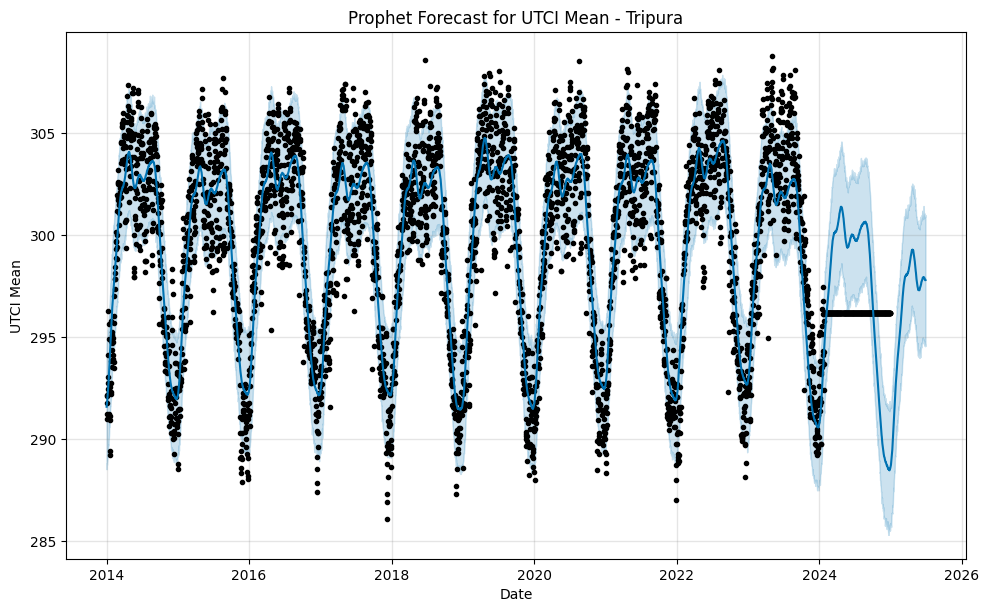

In [ ]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/content/filtered_2014_2024.csv")
df['date'] = pd.to_datetime(df['date'])

# Extract state from SourceFile
df['State'] = df['SourceFile'].str.replace('.csv', '')

# Filter for one state (Tripura)
tripura_df = df[df['State'] == 'Tripura'][['date', 'utci_mean']]
tripura_df = tripura_df.rename(columns={'date': 'ds', 'utci_mean': 'y'})

# Initialize and fit Prophet
model = Prophet()
model.fit(tripura_df)

# Forecast next 180 days
future = model.make_future_dataframe(periods=180)
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.title("Prophet Forecast for UTCI Mean - Tripura")
plt.xlabel("Date")
plt.ylabel("UTCI Mean")
plt.show()


In [ ]:
!pip install prophet


In [ ]:
from prophet import Prophet
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score
import os

# Load your dataset
df = pd.read_csv("filtered_2014_2024.csv")  # Upload in Colab first
df['date'] = pd.to_datetime(df['date'])
df['State'] = df['SourceFile'].str.replace('.csv', '')

# Create output folder
os.makedirs("prophet_forecasts", exist_ok=True)
states = df['State'].unique()
metrics = []

for state in states:
    state_df = df[df['State'] == state][['date', 'utci_mean']].rename(columns={'date': 'ds', 'utci_mean': 'y'})

    model = Prophet(yearly_seasonality=True)
    model.add_seasonality(name='half_yearly', period=180, fourier_order=5)
    model.fit(state_df)

    future = model.make_future_dataframe(periods=180)
    forecast = model.predict(future)
    forecast.to_csv(f"prophet_forecasts/{state}_forecast.csv", index=False)

    merged = pd.merge(state_df, forecast[['ds', 'yhat']], on='ds', how='inner')
    mae = mean_absolute_error(merged['y'], merged['yhat'])
    r2 = r2_score(merged['y'], merged['yhat'])
    metrics.append({'State': state, 'MAE': round(mae, 2), 'R2 Score': round(r2, 4)})

# Save metrics
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv("prophet_forecasts/prophet_model_metrics.csv", index=False)
metrics_df.head()


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppwwo3bx1/vi_q84gn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppwwo3bx1/g5oxdflz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59004', 'data', 'file=/tmp/tmppwwo3bx1/vi_q84gn.json', 'init=/tmp/tmppwwo3bx1/g5oxdflz.json', 'output', 'file=/tmp/tmppwwo3bx1/prophet_modelx8qacjqw/prophet_model-20250518122541.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:25:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:25:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppw

,State,MAE,R2 Score
0,Tripura,1.83,0.7721
1,Goa,1.42,0.5814
2,Nagaland,1.22,0.8779
3,Arunachal_Pradesh,1.49,0.8872
4,Jharkhand,1.86,0.8259


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['MAE'].plot(kind='hist', bins=20, title='MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['R2 Score'].plot(kind='hist', bins=20, title='R2 Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('State').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='MAE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='MAE', y='R2 Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['MAE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('State')):
  _plot_series(series, series_name, i)
  fig.legend(title='State', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('MAE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['R2 Score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('State')):
  _plot_series(series, series_name, i)
  fig.legend(title='State', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('R2 Score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('State')):
  _plot_series(series, series_name, i)
  fig.legend(title='State', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_9['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['MAE'].plot(kind='line', figsize=(8, 4), title='MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['R2 Score'].plot(kind='line', figsize=(8, 4), title='R2 Score')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_12['State'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_12, x='index', y='State', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['State'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='MAE', y='State', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['State'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='R2 Score', y='State', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
from prophet import Prophet
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score
import os

# Load dataset
df = pd.read_csv("filtered_2014_2024.csv")  # Upload this in Colab or local Jupyter
df['date'] = pd.to_datetime(df['date'])
df['State'] = df['SourceFile'].str.replace('.csv', '')

# Create directory to save output
os.makedirs("prophet_forecasts", exist_ok=True)

# Track metrics
metrics = []

# Loop through each state
for state in df['State'].unique():
    state_df = df[df['State'] == state][['date', 'utci_mean']].rename(columns={'date': 'ds', 'utci_mean': 'y'})

    model = Prophet(yearly_seasonality=True)
    model.add_seasonality(name='half_yearly', period=180, fourier_order=5)
    model.fit(state_df)

    future = model.make_future_dataframe(periods=180)
    forecast = model.predict(future)

    # Save forecast to CSV
    forecast_output = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    forecast_output.to_csv(f"prophet_forecasts/{state}_forecast.csv", index=False)

    # Calculate metrics
    merged = pd.merge(state_df, forecast[['ds', 'yhat']], on='ds', how='inner')
    mae = mean_absolute_error(merged['y'], merged['yhat'])
    r2 = r2_score(merged['y'], merged['yhat'])

    metrics.append({
        'State': state,
        'MAE': round(mae, 2),
        'R2 Score': round(r2, 4)
    })

# Save metrics
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv("prophet_forecasts/prophet_model_metrics.csv", index=False)
print("✅ Forecasts and metrics saved in 'prophet_forecasts/' folder.")


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppwwo3bx1/yay3k5eu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppwwo3bx1/8q4n6ufc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44883', 'data', 'file=/tmp/tmppwwo3bx1/yay3k5eu.json', 'init=/tmp/tmppwwo3bx1/8q4n6ufc.json', 'output', 'file=/tmp/tmppwwo3bx1/prophet_model0dnevhoa/prophet_model-20250518123159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:31:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:32:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppw

✅ Forecasts and metrics saved in 'prophet_forecasts/' folder.


In [ ]:
import shutil
from google.colab import files

# Zip the folder
shutil.make_archive("prophet_forecasts", 'zip', "prophet_forecasts")

# Download the zip
files.download("prophet_forecasts.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install --quiet contextily


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 52.2 MB/s eta 0:00:00


<ipython-input-11-e836ee3f7908>:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


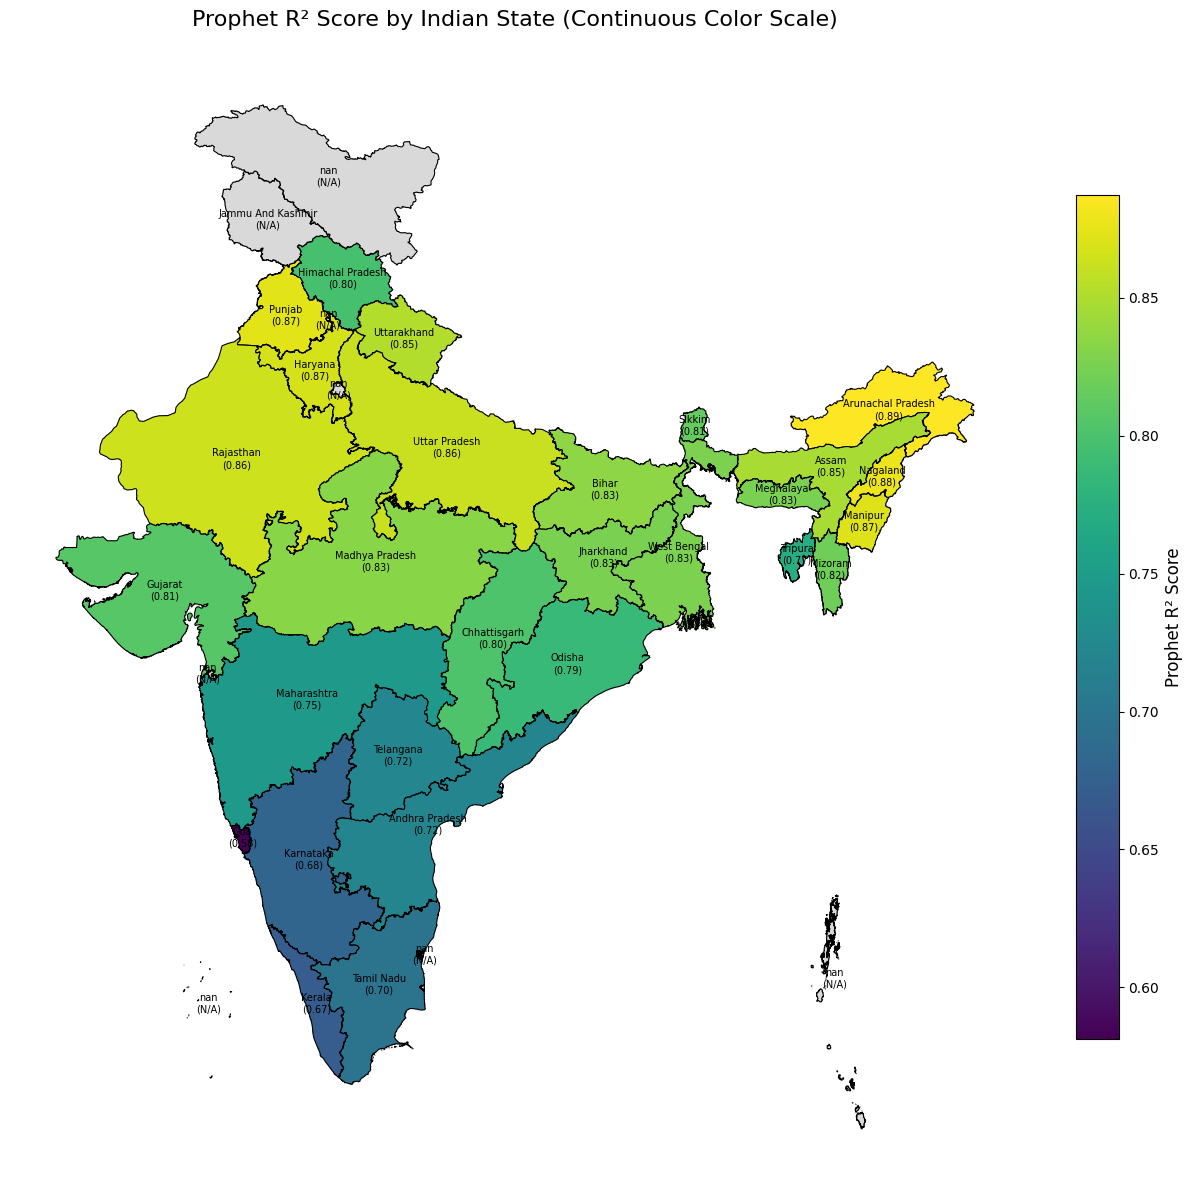

In [11]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import zipfile
import os

# === SETUP PATHS ===
zip_path = '/content/prophet_forecasts.zip'
extract_path = '/content/prophet_forecasts'
shapefile_path = '/content/Admin2.shp'  # Update this path if needed

# === UNZIP ===
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# === LOAD SHAPEFILE AND PROPHET METRICS ===
india_states = gpd.read_file(shapefile_path)
results = pd.read_csv(os.path.join(extract_path, 'prophet_model_metrics.csv'))

# === CLEAN STATE NAMES ===
india_states['ST_NM'] = india_states['ST_NM'].str.replace('&', 'and', regex=False)
india_states['ST_NM'] = india_states['ST_NM'].str.strip().str.title()
results['State'] = results['State'].str.replace('_', ' ')
results['State'] = results['State'].str.strip().str.title()

# === ADD JAMMU AND KASHMIR IF MISSING ===
if "Jammu And Kashmir" not in results['State'].values:
    new_row = pd.DataFrame([{
        'State': 'Jammu And Kashmir',
        'R2 Score': pd.NA
    }])
    results = pd.concat([results, new_row], ignore_index=True)

# === MERGE ===
merged = india_states.merge(results, left_on='ST_NM', right_on='State', how='left')

# === SETUP COLORMAP ===
cmap = plt.cm.viridis  # You can change to 'plasma', 'coolwarm', etc.
norm = mpl.colors.Normalize(vmin=results['R2 Score'].min(skipna=True), vmax=results['R2 Score'].max(skipna=True))

# Assign colors based on R² Score using colormap
merged['Color'] = merged['R2 Score'].apply(lambda x: cmap(norm(x)) if pd.notnull(x) else (0.85, 0.85, 0.85, 1.0))  # lightgray for NA

# === PLOT ===
fig, ax = plt.subplots(figsize=(15, 12))
merged.plot(color=merged['Color'], linewidth=0.8, edgecolor='black', ax=ax)

# Add labels
for idx, row in merged.iterrows():
    if row['geometry'].centroid.is_empty:
        continue
    x, y = row['geometry'].centroid.coords[0]
    label = f"{row['State']}\n({row['R2 Score']:.2f})" if pd.notnull(row['R2 Score']) else f"{row['State']}\n(N/A)"
    ax.text(x, y, label, ha='center', va='center', fontsize=7)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label("Prophet R² Score", fontsize=12)

# Final formatting
plt.title("Prophet R² Score by Indian State (Continuous Color Scale)", fontsize=16, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
pip install shap


In [ ]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

# Save the model
xgb_model.save_model("xgb_model.json")


Processing SHAP for state: Kerala


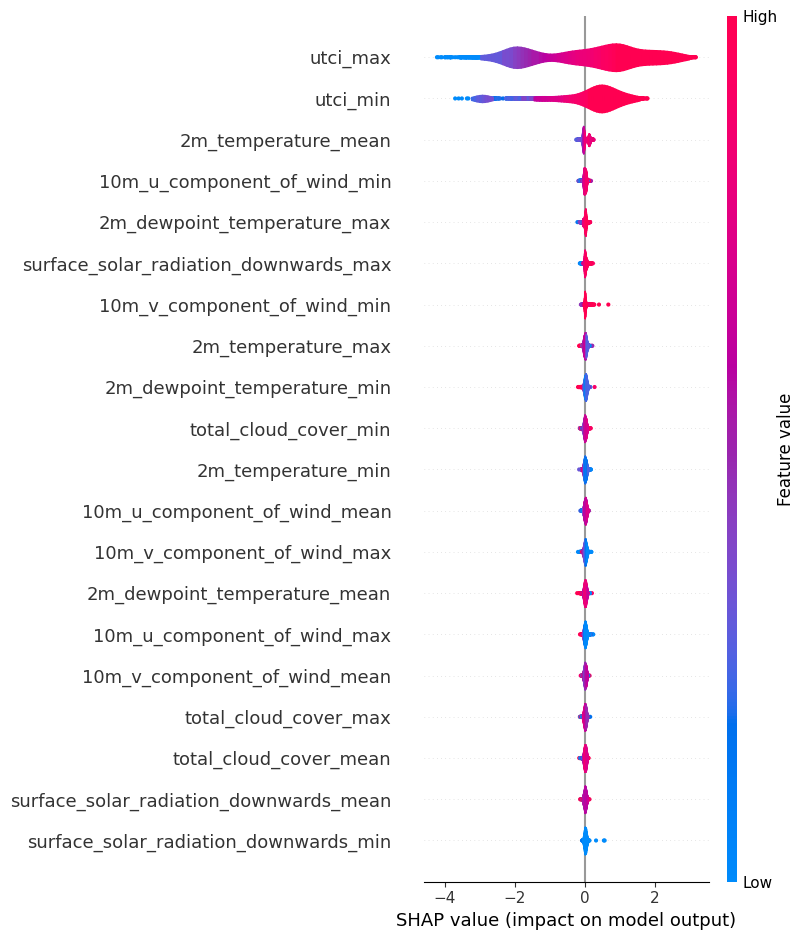

Processing SHAP for state: Andhra_Pradesh


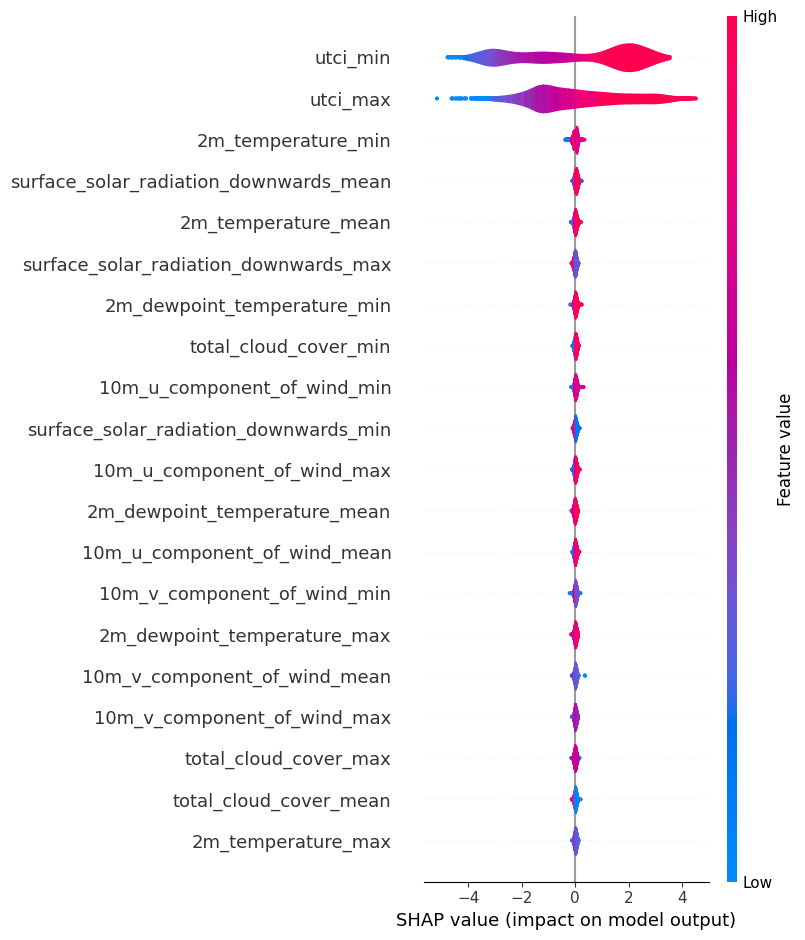

Processing SHAP for state: Punjab


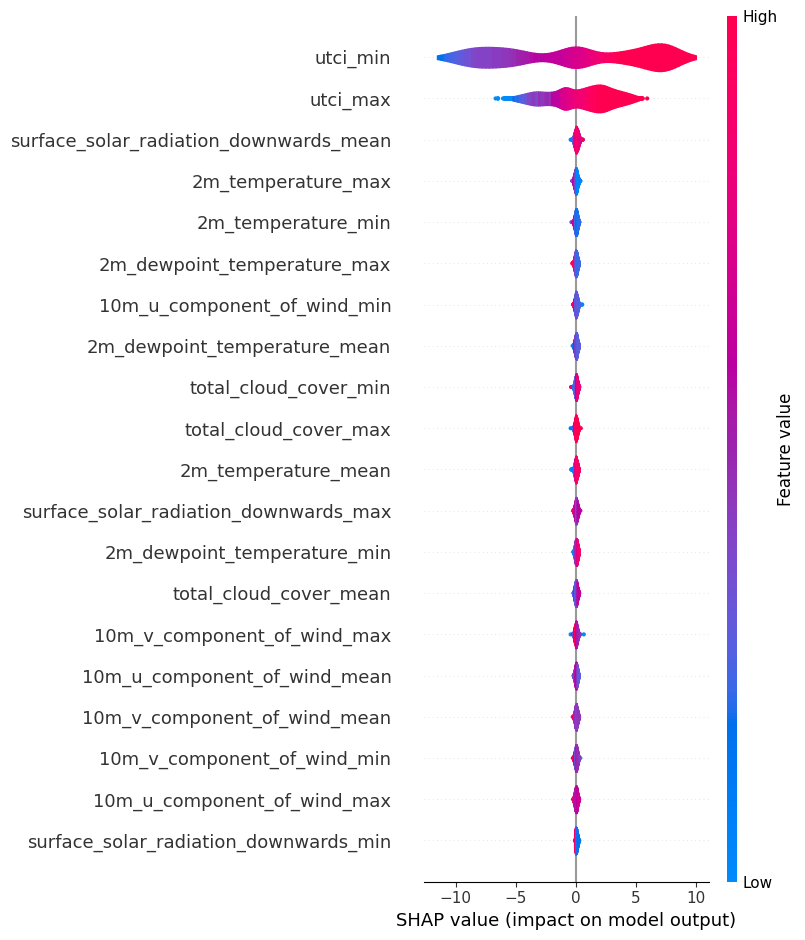

In [ ]:
import pandas as pd
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

# Load the main dataset
df_full = pd.read_csv("/content/filtered_2014_2024.csv")
df_full['state'] = df_full['SourceFile'].apply(lambda x: x.replace('.csv', ''))

# Define the target column
target_column = 'utci_mean' # Use the correct target column

# List of states to analyze
states_to_analyze = ['Kerala', 'Andhra_Pradesh', 'Punjab'] # Use underscore for Andhra Pradesh if that's how it appears in the 'state' column

# Loop through each state
for state in states_to_analyze:
    print(f"Processing SHAP for state: {state}")

    # Filter the main dataframe for the current state
    df = df_full[df_full['state'] == state].copy()

    # Define features (X) and target (y)
    # Ensure columns to drop exist or use errors='ignore' as you did before
    X = df.drop(columns=['date', 'SourceFile', 'state', target_column], errors='ignore')
    y = df[target_column]

    # Handle missing/infinite values in the target variable 'y'
    valid_indices = y.replace([np.inf, -np.inf], np.nan).dropna().index
    X_cleaned = X.loc[valid_indices]
    y_cleaned = y.loc[valid_indices]

    # Check if there's still data left after dropping
    if X_cleaned.empty or y_cleaned.empty:
        print(f"No valid data points left for state {state} after removing rows with missing/infinite target values.")
        continue # Skip to the next state if no valid data is left

    # Train XGBoost model
    model = xgb.XGBRegressor()
    model.fit(X_cleaned, y_cleaned) # Fit with cleaned data

    # SHAP Analysis
    explainer = shap.Explainer(model)
    # Use X_cleaned for SHAP values calculation
    shap_values = explainer(X_cleaned)

    # Plot SHAP Violin Summary
    # Use X_cleaned for the plot
    shap.summary_plot(shap_values, X_cleaned, plot_type="violin", show=True)


Processing region: All India

Processing region: Kerala

Processing region: Punjab


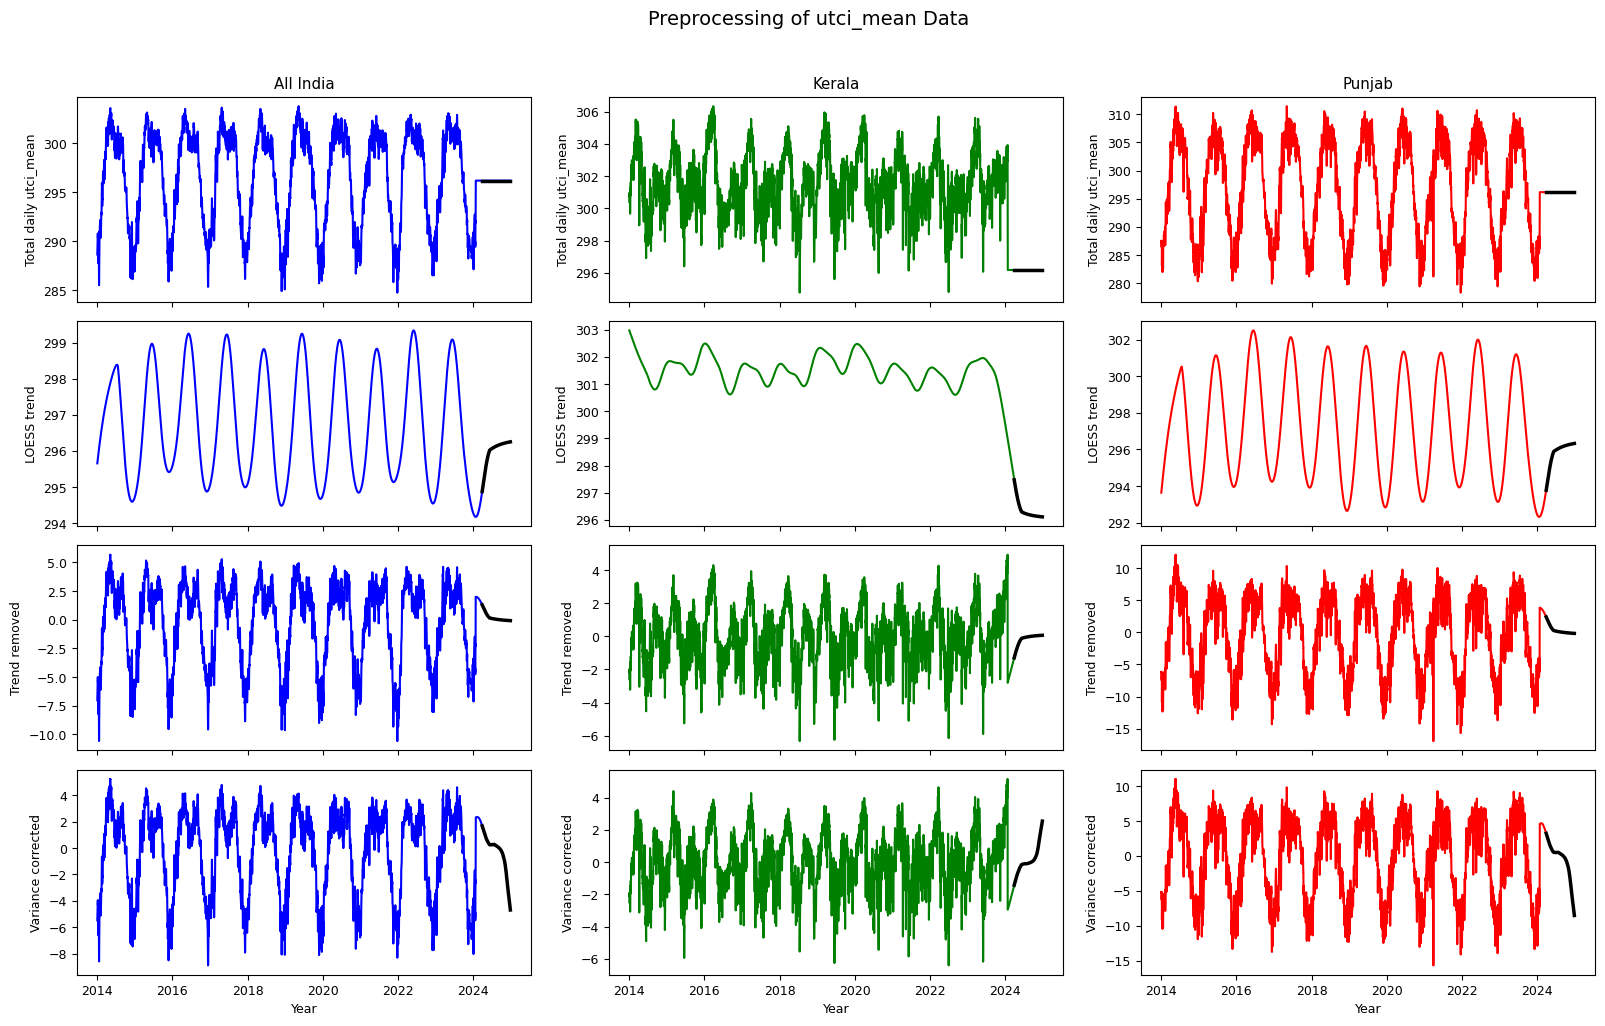

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Load the dataset
df = pd.read_csv('/content/filtered_2014_2024.csv')
df['date'] = pd.to_datetime(df['date'], dayfirst=True)  # Fix for DD-MM-YYYY format

# Extract state name
df['state'] = df['SourceFile'].apply(lambda x: x.replace('.csv', ''))

# Column to analyze
consumption_column = 'utci_mean'

# All India aggregate
all_india_df = df.groupby('date')[consumption_column].mean().reset_index()
all_india_df['state'] = 'All India'

# Regions and base colors
regions_to_plot = ['All India', 'Kerala', 'Punjab']
colors = ['blue', 'green', 'red']
highlight_color = 'black'

# Plot setup
fig, axs = plt.subplots(4, len(regions_to_plot), figsize=(16, 10), sharex=True)
fig.subplots_adjust(hspace=0.3)
plt.rcParams.update({'font.size': 9})

if len(regions_to_plot) == 1:
    axs = axs[:, np.newaxis]

for i, region in enumerate(regions_to_plot):
    print(f"\nProcessing region: {region}")
    region_data = all_india_df.copy() if region == 'All India' else df[df['state'] == region].copy()
    region_data = region_data.sort_values('date')

    if region_data.empty:
        continue

    april_2024 = pd.to_datetime("2024-04-01")
    mask_april = region_data['date'] >= april_2024

    # --- Raw UTCI plot ---
    axs[0, i].plot(region_data['date'], region_data[consumption_column], color=colors[i])
    axs[0, i].set_title(region)
    axs[0, i].set_ylabel(f"Total daily {consumption_column}")
    if mask_april.any():
        axs[0, i].plot(region_data.loc[mask_april, 'date'],
                      region_data.loc[mask_april, consumption_column],
                      color=highlight_color, linewidth=2.5)

    # --- LOESS trend ---
    if len(region_data) > 1:
        x_numeric = region_data['date'].apply(lambda x: x.timestamp()).values
        smoothed = lowess(region_data[consumption_column], x_numeric, frac=0.1, return_sorted=False)
        axs[1, i].plot(region_data['date'], smoothed, color=colors[i])
        axs[1, i].set_ylabel("LOESS trend")
        if mask_april.any():
            axs[1, i].plot(region_data.loc[mask_april, 'date'],
                          smoothed[mask_april],
                          color=highlight_color, linewidth=2.5)

        # --- Detrended ---
        detrended = region_data[consumption_column] - smoothed
        axs[2, i].plot(region_data['date'], detrended, color=colors[i])
        axs[2, i].set_ylabel("Trend removed")
        if mask_april.any():
            axs[2, i].plot(region_data.loc[mask_april, 'date'],
                          detrended[mask_april],
                          color=highlight_color, linewidth=2.5)

        # --- Variance correction ---
        if len(detrended) >= 30:
            temp_df = pd.DataFrame({'date': region_data['date'], 'detrended': detrended})
            temp_df = temp_df.set_index('date')
            rolling_std = temp_df['detrended'].rolling(window='365D', center=True, min_periods=30).std()
            std_2023 = rolling_std[rolling_std.index.year == 2023].dropna().mean()

            if not np.isnan(std_2023) and std_2023 != 0:
                variance_corrected = (detrended.values / rolling_std.values) * std_2023
                axs[3, i].plot(region_data['date'], variance_corrected, color=colors[i])
                axs[3, i].set_ylabel("Variance corrected")
                if mask_april.any():
                    axs[3, i].plot(region_data.loc[mask_april, 'date'],
                                  variance_corrected[mask_april],
                                  color=highlight_color, linewidth=2.5)
            else:
                axs[3, i].plot(region_data['date'], np.zeros_like(detrended), color=colors[i], linestyle='dashed')
                axs[3, i].set_ylabel("Variance corrected (skipped)")
        else:
            axs[3, i].plot(region_data['date'], detrended, color=colors[i], linestyle='dashed')
            axs[3, i].set_ylabel("Variance correction (skipped)")

# X-axis label
for j in range(len(regions_to_plot)):
    axs[3, j].set_xlabel("Year")

plt.suptitle(f"Preprocessing of {consumption_column} Data", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


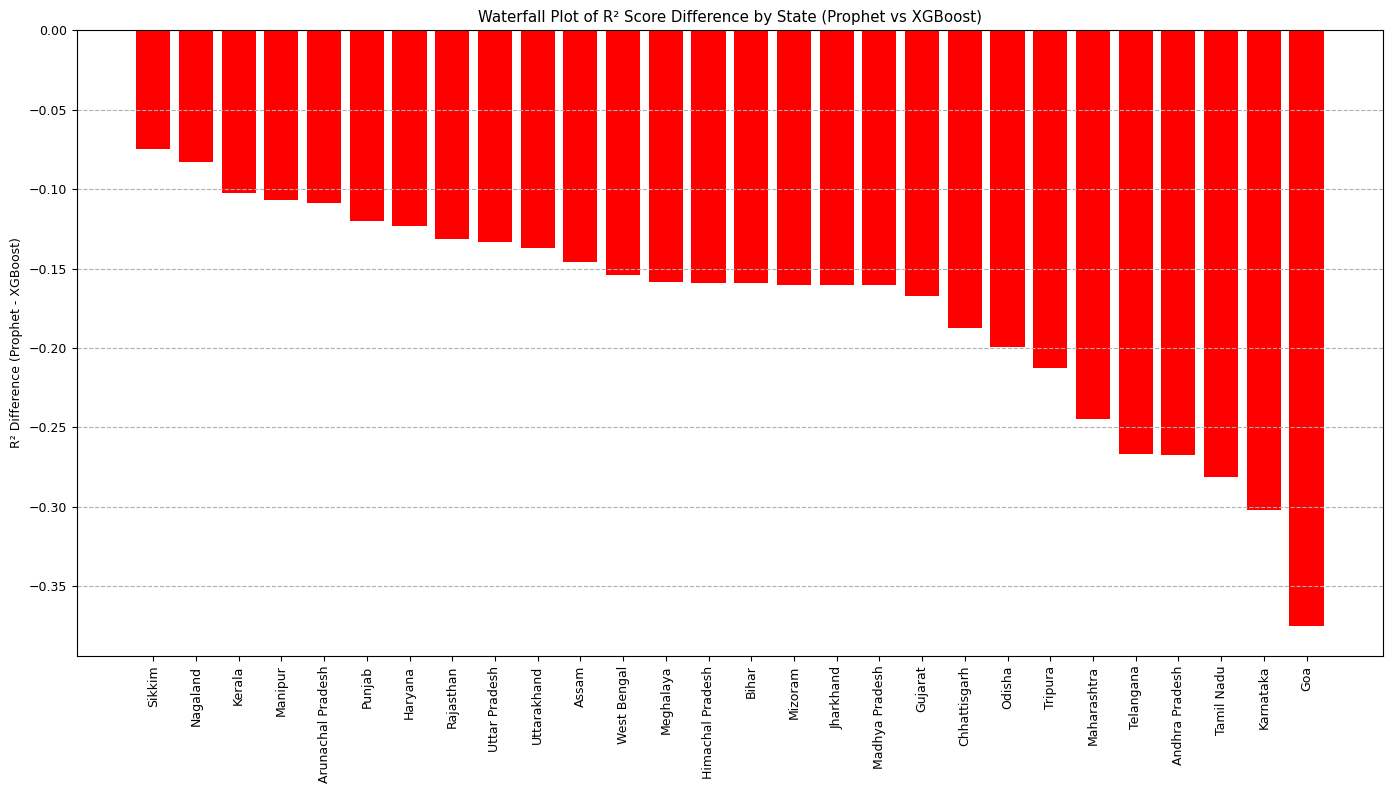

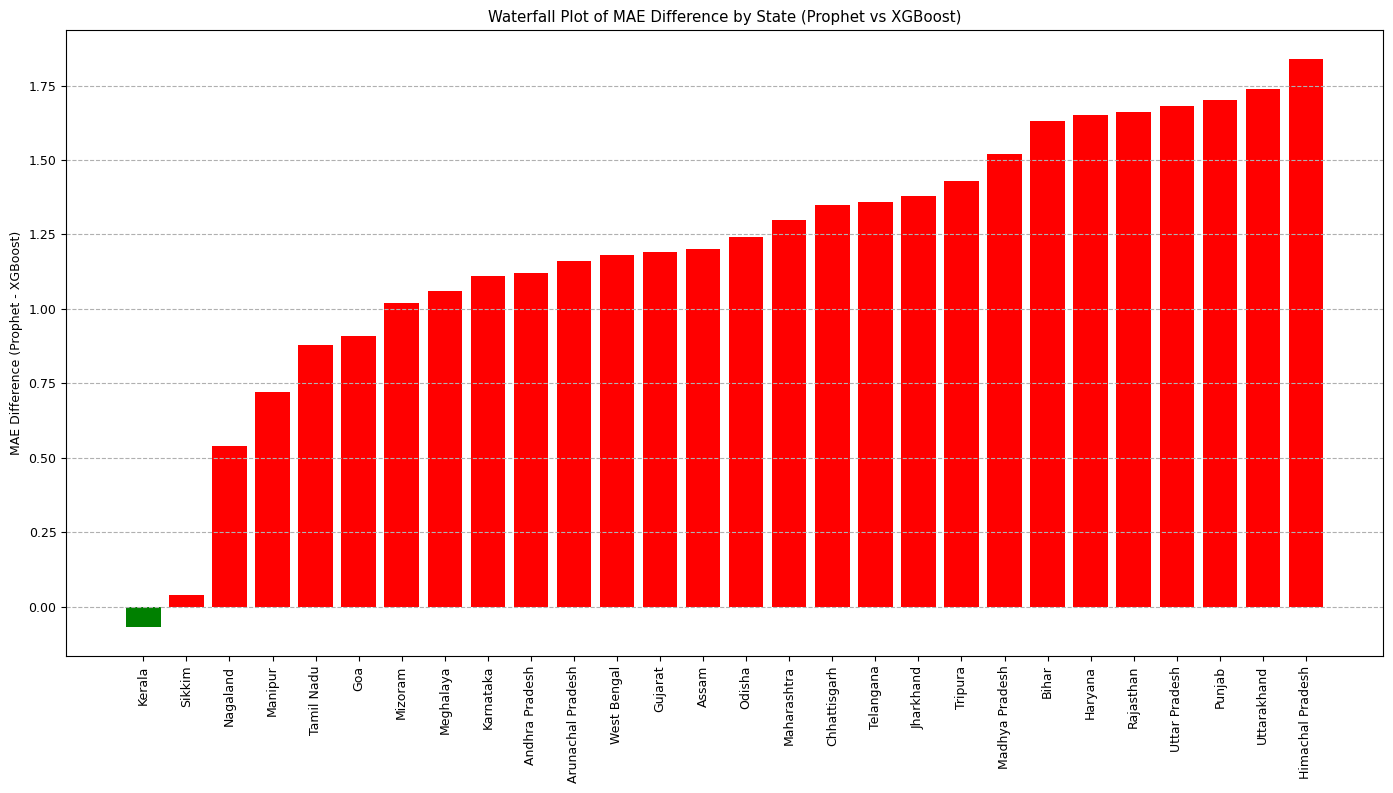

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load data ---
xgb_df = pd.read_csv("xgboost_all_states_results.csv")
prophet_df = pd.read_csv("/content/prophet_forecasts/prophet_model_metrics.csv")

# --- Preprocess ---
# Clean state names if needed
xgb_df['State'] = xgb_df['State'].str.replace('_', ' ').str.strip()
prophet_df['State'] = prophet_df['State'].str.replace('_', ' ').str.strip()

# Merge data on 'State'
merged = pd.merge(
    xgb_df[['State', 'R2 Score', 'MAE']].rename(columns={'R2 Score': 'XGB_R2', 'MAE': 'XGB_MAE'}),
    prophet_df[['State', 'R2 Score', 'MAE']].rename(columns={'R2 Score': 'PROPHET_R2', 'MAE': 'PROPHET_MAE'}),
    on='State',
    how='inner'
)

# Drop rows with missing values (if any)
merged.dropna(inplace=True)

# --- Calculate differences ---
merged['R2_Difference'] = merged['PROPHET_R2'] - merged['XGB_R2']         # Prophet better if positive
merged['MAE_Difference'] = merged['PROPHET_MAE'] - merged['XGB_MAE']     # Prophet better if negative

# === Plot 1: R² Difference (Prophet - XGBoost) ===
merged_r2_sorted = merged.sort_values('R2_Difference', ascending=False)

plt.figure(figsize=(14, 8))
plt.bar(
    merged_r2_sorted['State'],
    merged_r2_sorted['R2_Difference'],
    color=['green' if x > 0 else 'red' for x in merged_r2_sorted['R2_Difference']]
)
plt.xticks(rotation=90)
plt.ylabel("R² Difference (Prophet - XGBoost)")
plt.title("Waterfall Plot of R² Score Difference by State (Prophet vs XGBoost)")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# === Plot 2: MAE Difference (Prophet - XGBoost) ===
merged_mae_sorted = merged.sort_values('MAE_Difference', ascending=True)

plt.figure(figsize=(14, 8))
plt.bar(
    merged_mae_sorted['State'],
    merged_mae_sorted['MAE_Difference'],
    color=['green' if x < 0 else 'red' for x in merged_mae_sorted['MAE_Difference']]
)
plt.xticks(rotation=90)
plt.ylabel("MAE Difference (Prophet - XGBoost)")
plt.title("Waterfall Plot of MAE Difference by State (Prophet vs XGBoost)")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
